# Weather Time Series Strategy Notebook


## Our goals:
- Our strategy model can take weather conditions as parameters to simulate performance under different scenarios.
- Adjust strategies dynamically based on high-risk conditions (e.g., unexpected cloud cover).
- Optimise Energy Consumption: Knowing the hours of sunshine and solar irradiation helps us manage our energy reserves efficiently.
- Enhance Vehicle Design: Understanding temperature fluctuations allows for designing better cooling systems and ensures the solar panels' efficiency isn't compromised.
- Predict Challenges: Past data can help us anticipate potential hurdles.

### TODO:

- Data Exploration and Preprocessing
  - Visualize correlation and distributions of features over time(daily/hourly)

- Split data to train and test

  
- Scenario Analysis for Weather Conditions
  - Analyze features variance 
  - Define weather scenarios (e.g., clear skies, cloudy, rainy, windy) for risk management.
  
- Create a prediction model for a 24h race (approx. 16-22 september 2026)
- Export the 24h hour predicted model distribution as a paramter to our simulator


## Data collection method
By using solcast API, we managed to collect weather and irradiance data from the circuit zolder route location, the data collected in intervals of 5 minutes and using UTC time format.

![API_features](media/API_features.png)

### The chosen features:
1. GHI - "Global Horizontal Irradiance" refers to the total solar radiation received per unit area on a horizontal surface, which helps estimate how much energy is available from all incoming solar radiation, including diffuse sunlight, which can affect the car even when it's not directly facing the sun. `(W/m²)`  
2. DNI - "Direct normal irradiance" represents the quantity of radiation received per unit area on a surface perpendicular to the sun. `(W/m²)`
3. cloud_opacity - Indicates how much sunlight is blocked by clouds. `(%)`
4. Air_temp - Calculated 2m above ground level, Affects solar car efficiency, battery performance and cooling needs. `Celsius (°C)`
5. Wind Speed (10m) - Relevant for aerodynamic drag and car speed optimization. `Meters per second (m/s)`
6. Wind direction (10m)  - See #5. `Degrees (°)`
7. Clearsky_DNI -  additional optimal scenario data. `(W/m²)`
8. Clearsky_GHI - See #7. `(W/m²)`
9. Percipitable_water - Percipitable water can absorb incoming solar radiation at the atmosphere. `Millimeters (mm)`
10. Percipitation_rate - Affects the chance of rain, and indicates the rate of change to #9.` Millimeters per hour (mm/h)`


In [2]:
# notebook imports
import pandas as pd
from datetime import datetime
import pytz
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Initialize an empty list to store DataFrames
dfs = []

# Loop through the years and read the CSV files
for i in range(2014, 2025):
    df_temp = pd.read_csv(f'Data/{i}/{i}.csv')
    df_temp = df_temp.drop(columns=['period'])
    dfs.append(df_temp)

# Concatenate all DataFrames in the list
df = pd.concat(dfs, ignore_index=True)

# Display the DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91872 entries, 0 to 91871
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   air_temp            91872 non-null  int64  
 1   clearsky_dni        91872 non-null  int64  
 2   clearsky_ghi        91872 non-null  int64  
 3   cloud_opacity       91872 non-null  float64
 4   dni                 91872 non-null  int64  
 5   ghi                 91872 non-null  int64  
 6   precipitable_water  91872 non-null  float64
 7   precipitation_rate  91872 non-null  float64
 8   wind_direction_10m  91872 non-null  int64  
 9   wind_speed_10m      91872 non-null  float64
 10  period_end          91872 non-null  object 
dtypes: float64(4), int64(6), object(1)
memory usage: 7.7+ MB


### As we can see, there is no empty cells in our dataset

In [4]:
df.describe()

,air_temp,clearsky_dni,clearsky_ghi,cloud_opacity,dni,ghi,precipitable_water,precipitation_rate,wind_direction_10m,wind_speed_10m
count,91872.000000,91872.000000,91872.000000,91872.000000,91872.000000,91872.000000,91872.000000,91872.000000,91872.000000,91872.000000
mean,15.170367,305.275688,191.257032,31.197032,135.792091,132.856616,22.625328,0.098785,187.789141,3.227190
std,4.486312,343.095779,240.391061,31.982306,262.328472,191.354002,6.828265,0.362082,84.570232,1.619955
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000
25%,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.400000,0.000000,124.000000,2.000000
50%,15.000000,8.000000,7.000000,23.100000,0.000000,3.000000,21.600000,0.000000,206.000000,2.900000
75%,18.000000,684.000000,418.000000,58.400000,79.000000,221.000000,27.000000,0.000000,243.000000,4.100000
max,34.000000,910.000000,730.000000,97.000000,910.000000,729.000000,50.000000,6.900000,360.000000,11.300000


In [5]:
df.head()

,air_temp,clearsky_dni,clearsky_ghi,cloud_opacity,dni,ghi,precipitable_water,precipitation_rate,wind_direction_10m,wind_speed_10m,period_end
0,16,0,0,0.0,0,0,29.2,0.0,238,1.0,2014-09-06T00:05:00+00:00
1,16,0,0,0.0,0,0,29.2,0.0,238,1.0,2014-09-06T00:10:00+00:00
2,16,0,0,0.0,0,0,29.2,0.0,238,1.0,2014-09-06T00:15:00+00:00
3,16,0,0,0.0,0,0,29.2,0.0,238,1.0,2014-09-06T00:20:00+00:00
4,16,0,0,0.0,0,0,29.2,0.0,238,1.1,2014-09-06T00:25:00+00:00


 Some conversion (UTC to local time) is needed..

In [6]:
# Converting UTC to the circuit zolder local time
target_timezone = pytz.timezone('Europe/Brussels')

def convert_to_local_time(utc_time_str):
    utc_time = datetime.fromisoformat(utc_time_str)  
    local_time = utc_time.astimezone(target_timezone)
    return local_time

df['local_time'] = df['period_end'].apply(convert_to_local_time)
df = df.drop(columns=['period_end'])

In [7]:
# Splitting date and time
df['local_time'] = pd.to_datetime(df['local_time'])
df['date'] = df['local_time'].dt.date
df['time'] = df['local_time'].dt.time
df = df.drop(columns=['local_time'])

In [8]:
df.value_counts('time')

time
22:35:00    319
22:30:00    319
22:25:00    319
22:20:00    319
22:15:00    319
           ... 
00:20:00    319
00:15:00    319
00:10:00    319
00:05:00    319
00:00:00    319
Name: count, Length: 288, dtype: int64

### Next, we will show data distributions over time and correlation matrix

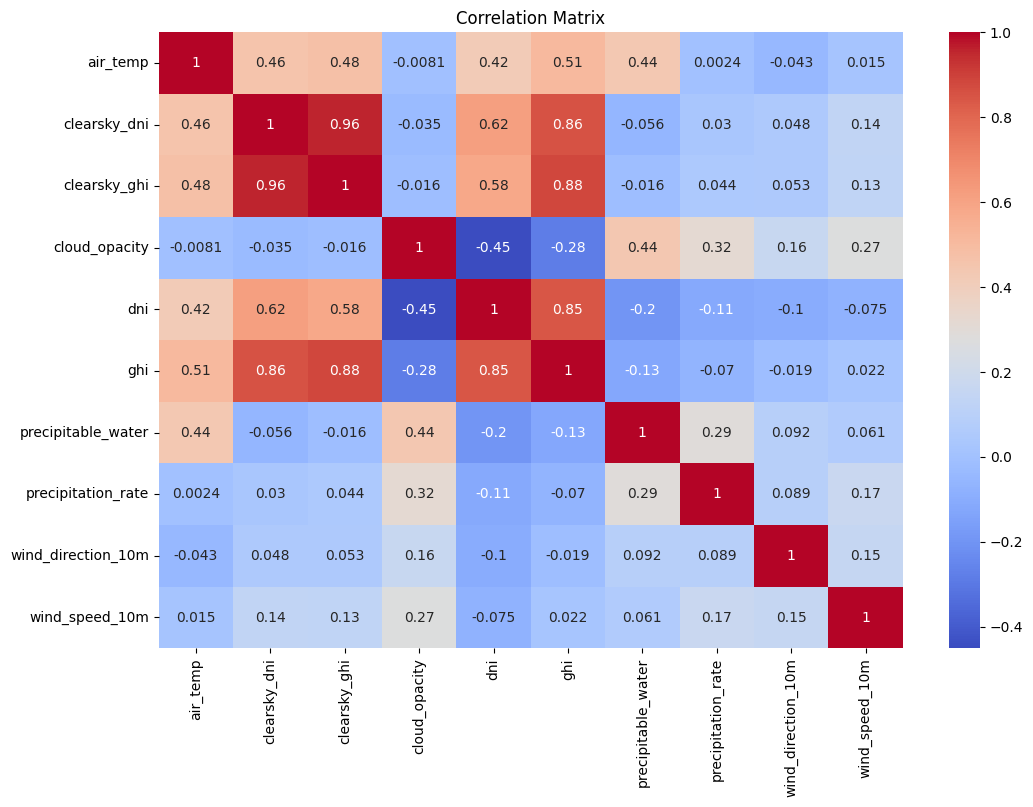

In [9]:
# Exclude date feature
numerical_df = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numerical_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.show()


Main insights from the correlation matrix: 
1. GHI has 0.51 correlation with air_temp 
2. There is weak negative correlation between cloud_opacity and GHI (-0.28) 

Next we will show some visualizations:
1. Total GHI per day distribution
2. Average GHI per hour distribution
3. cloud_opacity vs GHI
4. wind direction + speed patterns
5. air_temp vs GHI
6. GHI vs DNI
7. percipitation rate vs percitipation water distribution
8. clearsky vs actual radiation

In [35]:
# Function to calculate the distribution of parameter per hour between dates
def calculate_hourly_avg(df, parameter, start_date, end_date):
    # Filter DataFrame between the start and end date
    filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    # Extract hour from the time feature
    filtered_df.loc[:, 'hour'] = filtered_df['time'].apply(lambda x: x.hour)
    # Calculate the hourly average of the parameter
    hourly_avg = filtered_df.groupby('hour')[parameter].mean()
    return hourly_avg

In [36]:
# Function to plot the distribution of parameter per hour
def plot_hourly_avg(hourly_avg, parameter, start_date, end_date):
    plt.figure(figsize=(12, 8))
    sns.barplot(x=hourly_avg.index, y=hourly_avg.values)
    plt.title(f'{parameter} Distribution per Hour between {start_date} and {end_date}')
    plt.xlabel('Hour')
    plt.ylabel(parameter)
    plt.grid()
    plt.show()

C:\Users\erez1\AppData\Local\Temp\ipykernel_12800\749298408.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'hour'] = filtered_df['time'].apply(lambda x: x.hour)


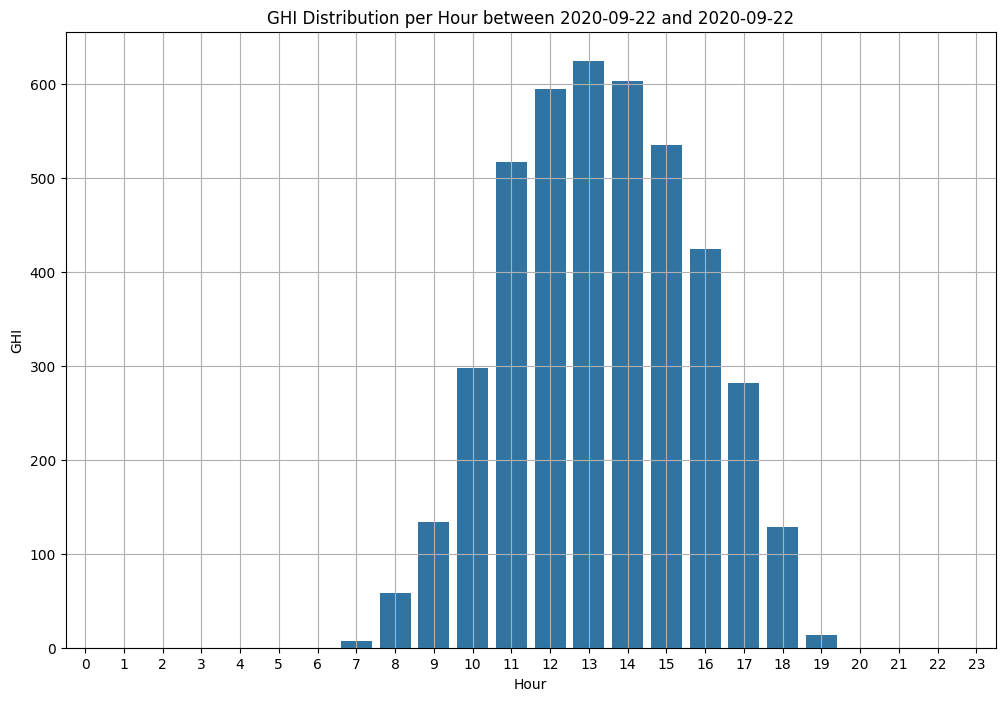

In [37]:
start_date = datetime(2020, 9, 22).date()
end_date = datetime(2020, 9, 22).date()

# Calculate and plot the distribution of GHI per hour
hourly_avg = calculate_hourly_avg(df, 'ghi', start_date, end_date)
plot_hourly_avg(hourly_avg, 'GHI', start_date, end_date)